In [1]:
# Load self-defined functions.
%run tools.ipynb

# Import libraries.
import os
import time
import shutil
import pickle

from KRFD import KRFD_model # KRFD model.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import optuna # For Bayesian optimization of the hyper-parameters of KRFD.
from sklearn.model_selection import KFold
import joblib

optuna.logging.set_verbosity(optuna.logging.WARNING) ## Silence the outputs of optuna.

# Create a directory for saving results.
new_dir = "Artificial_data_dense"
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)
os.mkdir(new_dir)

In [2]:
# Set random seed.
np.random.seed(seed=1122)

# Create an artificial data set (dense functional data).
num_X = 1000 # Number of samples.
sigma = 0.2 # Sigma of observation noise.

# Set the parameters of the function y = f(t).
a = np.random.uniform(1, 5, num_X)  # amplitude
b = np.random.uniform(1, 5, num_X)  # frequency
c = np.random.uniform(0, 3, num_X)  # phase
d = np.random.uniform(-2, 2, num_X) # slope
e = np.random.uniform(-3, 3, num_X) # intercept

# X
X = np.array([a,b,c,d,e]).T
print(f"X: {X.shape}")

# t
t = np.linspace(0, 2, 51) 
print(f"t: {len(t)}")

# Y
Y = np.array([X[i,0] * np.sin(X[i,1]*t + X[i,2]) + X[i,3]*t + X[i,4] + np.random.normal(0, sigma, len(t)) \
 for i in range(num_X)])
print(f"Y: {Y.shape}")

# Divide data into training and test set.
divided_samples = train_test_split(num_X, test_prop=0.25)

X_train = X[divided_samples["train_ids"]]
Y_train = Y[divided_samples["train_ids"]]
X_test = X[divided_samples["test_ids"]]
Y_test = Y[divided_samples["test_ids"]]
print(f"training: {X_train.shape[0]}, test: {X_test.shape[0]}")

# Y_true for plotting.
Y_true = np.array([X[i,0] * np.sin(X[i,1]*t + X[i,2]) + X[i,3]*t + X[i,4] for i in range(num_X)])
Y_true_test = Y_true[divided_samples["test_ids"]] 

# Get K-folds cross-validation dataset.
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
k_folds = []
for cv_train_index, cv_test_index in kf.split(X_train):
    # train-test split for cv.
    cv_X_train, cv_X_test = X_train[cv_train_index], X_train[cv_test_index]
    cv_Y_train, cv_Y_test = Y_train[cv_train_index], Y_train[cv_test_index]
    k_folds.append({"X_train":cv_X_train, "X_test":cv_X_test, "Y_train":cv_Y_train, "Y_test":cv_Y_test})

X: (1000, 5)
t: 51
Y: (1000, 51)
training: 750, test: 250


In [3]:
# Define functions.

# Define a function for parallel cross-validation for a given model.
def model_cv(i, model, k_folds = k_folds):
    # Training model.
    model.fit(k_folds[i]["X_train"], t, k_folds[i]["Y_train"])
    # Validation on test-set.
    pred = model.predict(k_folds[i]["X_test"], t)
    MAE = np.mean(np.abs(pred - k_folds[i]["Y_test"]))
    return MAE

# Test metrics.
def test_metrics(Y_pred_test, Y_test):
    pred = Y_pred_test.flatten()
    obs = Y_test.flatten()
    
    MAE = np.mean(np.abs(pred - obs))
    RMSE = (np.mean((pred - obs)**2))**(1/2)
    R2 = (np.corrcoef(pred, obs)[0, 1])**2
    return MAE, RMSE, R2

# Function for plotting pred vs obs graph.
def pred_obs_plot(Y_pred_test, Y_test, address, dpi = 400):
    # Plot Prediction vs Onservation plot on the test set.
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    # Calculate metrics.
    pred, obs = Y_pred_test.flatten(), Y_test.flatten()
    MAE, RMSE, R2 = test_metrics(Y_pred_test, Y_test)
    # Scatter plot.
    ax.scatter(pred, obs)
    labels = []
    labels.append(f"MAE = {MAE:.3f}")
    labels.append(f"RMSE = {RMSE:.3f}")
    labels.append(r"$R^2=$"+f"{R2:.3f}")
    
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white",lw=0, alpha=0)] * 4
    ax.legend(handles, labels, loc='best', fontsize='x-large',fancybox=True, framealpha=0.7,handlelength=0, handletextpad=0)
    plt.title(f"Pred vs Obs on test set (N={Y_test.shape[0]}*{Y_test.shape[1]})", fontsize="xx-large")
    
    plt.xlabel(r"Prediction", fontsize="xx-large")
    plt.ylabel(r"Observation", fontsize="xx-large")
    margin = 1.05
    plt.xlim(min(np.min(pred),np.min(obs))*margin, max(np.max(pred),np.max(obs))*margin)
    plt.ylim(min(np.min(pred),np.min(obs))*margin, max(np.max(pred),np.max(obs))*margin)
    diag = np.linspace(min(np.min(pred),np.min(obs))*margin, max(np.max(pred),np.max(obs))*margin)
    plt.plot(diag, diag, '--', color = "grey") 
    fig.tight_layout()
    plt.savefig(address, dpi = 400)
    
# Save indivisual functional predictions.
def Save_plot(X_test, Y_test, Y_pred_test, Y_true_test, t, new_dir, dpi = 400):
    # Create new directory.
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    # Save individual plots.
    for i in range(Y_pred_test.shape[0]):
        fig = plt.figure(figsize=(6,4))
        plt.scatter(t, Y_test[i,:], label="Obs",color = "red", s = 2)
        plt.plot(t, Y_true_test[i,:], label="True",color = "gray")
        plt.plot(t, Y_pred_test[i,:], label="Pred",color = "cyan")
        plt.legend()
        plt.title(f"X = [amp: {X_test[i,0]:.2f},frq: {X_test[i,1]:.2f},phs: {X_test[i,2]:.2f},slp: {X_test[i,3]:.2f},int: {X_test[i,4]:.2f}]", fontsize="large")
        plt.xlim(-0.05, 2.05)
        plt.xlabel("t", fontsize="large")
        plt.ylabel("Y(X, t)", fontsize="large")
        fig.tight_layout()
        plt.savefig(f"{new_dir}/{i+1}-amp{X_test[i,0]:.2f}-frq{X_test[i,1]:.2f}-phs{X_test[i,2]:.2f}-slp{X_test[i,3]:.2f}-int{X_test[i,4]:.2f}.png", dpi = dpi)
        plt.close()

Best hyper-parameters: {'sigma_G': 1.9626636347382016, 'sigma_T': 0.4655288516256745, 'sigma_M': 13.026496743638353, 'lambda_G': 0.0001724627258593973, 'lambda_T': 0.05208350120142222, 'lambda_M': 1.4997737377282668e-05, 'kernel_X': 'Gaussian', 'kernel_T': 'Gaussian'}
Best validation MAE: 0.23549099448372512
Calculation time: 48.78890609741211


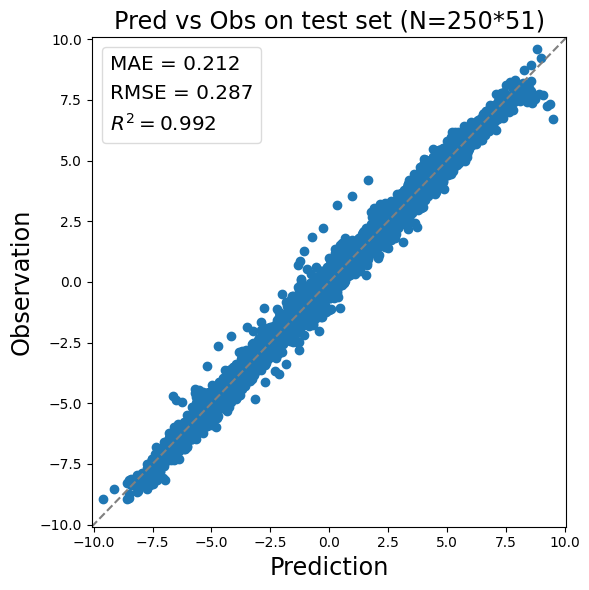

In [4]:
### KRFD on the dense functional data.

# Define an optuna-objective function.
def objective(trial):

    # Set region of the hyper-parameters of the KRFD model.
    sigma_G = trial.suggest_float('sigma_G', 0.1, 100, log = True)
    sigma_T = trial.suggest_float('sigma_T', 0.1, 100, log = True)
    sigma_M = trial.suggest_float('sigma_M', 0.1, 100, log = True)
    
    lambda_G = trial.suggest_float('lambda_G', 1e-06, 1, log = True)
    lambda_T = trial.suggest_float('lambda_T', 1e-06, 1, log = True)
    lambda_M = trial.suggest_float('lambda_M', 1e-06, 1, log = True)
    
    kernel_X = trial.suggest_categorical('kernel_X', ['Gaussian', 'Laplacian'])
    kernel_T = trial.suggest_categorical('kernel_T', ['Gaussian', 'Laplacian'])
    
    # Set hyper-parameters.
    krfd = KRFD_model([sigma_G, sigma_T, sigma_M],[lambda_G, lambda_T, lambda_M], 
                      kernel_types = [kernel_X, kernel_T])
    
    # Cross-validation with multicores.
    score = joblib.Parallel(n_jobs=-1)(joblib.delayed(model_cv)(i, model = krfd) for i in range(len(k_folds)))
    
    return np.mean(score)

# Run optuna for hyper-parameter optimization.
start = time.time()
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42)) # Set seed.
study.optimize(objective, n_trials=300)
study.trials_dataframe().to_csv(f"{new_dir}/KRFD_study.csv")
print(f"Best hyper-parameters: {study.best_params}")
print(f"Best validation MAE: {study.best_value}")
end = time.time()
print(f"Calculation time: {end - start}")

# Train KRFD model with the selected hyper-parameters.
best_sigmas = [study.best_trial.params['sigma_G'], study.best_trial.params['sigma_T'],
                     study.best_trial.params['sigma_M']]
best_lambdas = [study.best_trial.params['lambda_G'], study.best_trial.params['lambda_T'],
                study.best_trial.params['lambda_M']]
best_kernels = [study.best_trial.params['kernel_X'], study.best_trial.params['kernel_T']]

krfd = KRFD_model(best_sigmas, best_lambdas, kernel_types = best_kernels) # Set the selected hyper-parameters.
krfd.fit(X_train, t, Y_train) # Training model.

# Make predictions on test set.
Y_pred_test = krfd.predict(X_test, t)
    
# Plot results.
pred_obs_plot(Y_pred_test, Y_test, f"{new_dir}/ArtificialDense_KRFD.png") # parity plot.
Save_plot(X_test, Y_test, Y_pred_test,
          Y_true_test, t, f"{new_dir}/KRFD", 200) # indivisual results.

In [5]:
### Bayesian prediction with the trained KRFD model.

# 1. Output predicition means and stds for the test set.
Y_pred_mean_test, Y_pred_std_test = krfd.predict(X_test, t, std = True)

# Save individual prediction results for the test set.
start = time.time()

new_dir_std = f"{new_dir}/KRFD (mean ± std)"
if os.path.exists(new_dir_std):
    shutil.rmtree(new_dir_std)
os.mkdir(new_dir_std)

for i in range(Y_pred_mean_test.shape[0]):
    fig = plt.figure(figsize=(6,4))
    plt.scatter(t, Y_test[i,:], label="Obs",color = "red", s = 2)
    plt.plot(t, Y_true_test[i,:], label="True",color = "gray")
    plt.plot(t, Y_pred_mean_test[i,:], label="Pred_mean",color = "cyan")
    # add one sigma band.
    plt.fill_between(t, Y_pred_mean_test[i,:]-Y_pred_std_test[i,:], Y_pred_mean_test[i,:]+Y_pred_std_test[i,:],
                 alpha=.5, label='mean ± std')
    
    plt.legend()
    plt.title(f"X = [amp: {X_test[i,0]:.2f},frq: {X_test[i,1]:.2f},phs: {X_test[i,2]:.2f},slp: {X_test[i,3]:.2f},int: {X_test[i,4]:.2f}]", fontsize="large")
    plt.xlim(-0.05, 2.05)
    plt.xlabel("t", fontsize="large")
    plt.ylabel("Y(X, t)", fontsize="large")
    fig.tight_layout()
    plt.savefig(f"{new_dir_std}/{i+1}-amp{X_test[i,0]:.2f}-frq{X_test[i,1]:.2f}-phs{X_test[i,2]:.2f}-slp{X_test[i,3]:.2f}-int{X_test[i,4]:.2f}.png", dpi = 200)
    plt.close()
    
end = time.time()
print(f"Calculation time: {end - start}")

# 2. Sampling of predicted funcutions for the test set.
size = 300

np.random.seed(seed=1122) # Set random seed.
test_sampling = krfd.predict_sampling(X_test, t, size)

# Save individual prediction results for the test set.
start = time.time()

new_dir_samp = f"{new_dir}/KRFD (sampling)"
if os.path.exists(new_dir_samp):
    shutil.rmtree(new_dir_samp)
os.mkdir(new_dir_samp)

for i in range(Y_pred_test.shape[0]):
    fig = plt.figure(figsize=(6,4))
    plt.plot(t, test_sampling[i][0,:], color = "cyan", alpha = 0.1, label = f"Samps (N={size})")
    for j in range(1, test_sampling[i].shape[0]):
        plt.plot(t, test_sampling[i][j,:], color = "cyan", alpha = 0.1)
    plt.scatter(t, Y_test[i,:], label="Obs",color = "red", s = 2)
    plt.plot(t, Y_true_test[i,:], label="True",color = "gray")
    legend = plt.legend()
    for legend_handle in legend.legend_handles:
        legend_handle.set_alpha(1) # Set legend alpha to 1.
    plt.title(f"X = [amp: {X_test[i,0]:.2f},frq: {X_test[i,1]:.2f},phs: {X_test[i,2]:.2f},slp: {X_test[i,3]:.2f},int: {X_test[i,4]:.2f}]", fontsize="large")
    plt.xlim(-0.05, 2.05)
    plt.xlabel("t", fontsize="large")
    plt.ylabel("Y(X, t)", fontsize="large")
    fig.tight_layout()
    plt.savefig(f"{new_dir_samp}/{i+1}-amp{X_test[i,0]:.2f}-frq{X_test[i,1]:.2f}-phs{X_test[i,2]:.2f}-slp{X_test[i,3]:.2f}-int{X_test[i,4]:.2f}.png", dpi = 200)
    plt.close()
    
end = time.time()
print(f"Calculation time: {end - start}")

Calculation time: 31.872445821762085


/Users/minorukusaba/Desktop/KRFD/KRFD.py:362: RuntimeWarning: covariance is not positive-semidefinite.
  pred_sampling = np.random.multivariate_normal(pred_mean, pred_cov, size) # random sampling.


Calculation time: 79.78141903877258
